In [1]:
import pandas as pd
import numpy as np
import nltk
import itertools
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report

In [2]:
import datetime

In [3]:
import winsound
def beep(reps=1, duration=500, freq=440, sleep=1):
    for _ in range(reps - 1):
        winsound.Beep(freq, duration)
        time.sleep(sleep)
    winsound.Beep(freq, duration)

In [4]:
# data = "amazon_reviews/dataset/Video_Games_5.json.gz"
data = "amazon_reviews/dataset/Cell_Phones_and_Accessories_5.json.gz"
df = pd.read_json(data, lines = True, compression = "gzip")
df.head()

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


## Preprocessing/Normalization

In [5]:
df['reviewText'].loc[520]

"I am using the FreeSpeak for non-Bluetooth phones with my new T68i and I love it.  The Bluetooth multi-adapter for my old non-Bluetooth phone worked great, but the phone didn't support headset initiated call answering, voice dialing or call ending []a pain if you're going to be using any headset.\nSo I got the T68i and I am finally enjoying true cordless freedom.\nAs a note, I do notice that my range with the T68i is far less than with the Jabra multi-adapter.  With the adapter I got a good 30 feet of range from the phone/adapter to the headset.  With the T68i, I'm geting maybe ten feet, max.  Apparently SonyEricsson's implementation of Bluetooth isn't up to par.  But you can't fault the headset for that.\nAlso, I think the belt-clip/charger needs some sort of positive lock to prevent losing the headset which with its light weight makes little noise when it's dropped and to secure its position while charging."

In [6]:
before = datetime.datetime.now()

df['reviewText'] = df['reviewText'].str.replace('[.,;:;!?%]+', '')
# rimuove parole che contengono numeri (e lo spazio dopo); è un po' lento
df['reviewText'] = df['reviewText'].str.replace("\S*\d+\S*\s", '')
df['reviewText'] = df['reviewText'].str.lower()

after = datetime.datetime.now()
(after - before).seconds

39

In [7]:
df['reviewText'].loc[520]

"i am using the freespeak for non-bluetooth phones with my new and i love it  the bluetooth multi-adapter for my old non-bluetooth phone worked great but the phone didn't support headset initiated call answering voice dialing or call ending []a pain if you're going to be using any headset\nso i got the and i am finally enjoying true cordless freedom\nas a note i do notice that my range with the is far less than with the jabra multi-adapter  with the adapter i got a good feet of range from the phone/adapter to the headset  with the i'm geting maybe ten feet max  apparently sonyericsson's implementation of bluetooth isn't up to par  but you can't fault the headset for that\nalso i think the belt-clip/charger needs some sort of positive lock to prevent losing the headset which with its light weight makes little noise when it's dropped and to secure its position while charging"

Per la sentiment analysis potrebbe essere utile tenere conto delle occorrenze di "not", soprattutto in coppia con altri termini (quando usiamo $n$-grams), e.g. "not good", "not recommend", ecc., quindi potrebbe avere senso estrarre le occorrenze di "not" da forme contratte come "isn't", ecc. Alcuni esempi di parole contratte (con "not"):

In [8]:
from nltk.corpus import stopwords

In [9]:
stopws = stopwords.words("english")

In [10]:
np.array(stopws[-36:])

array(['ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
       'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
       "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
       "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
       "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
       'wouldn', "wouldn't"], dtype='<U9')

In [11]:
df['reviewText'].loc[1]

"when you don't want to spend a whole lot of cash but want a great dealthis is the shop to buy from"

In [12]:
# Ci mette qualche secondo (cercare alternative più veloci in caso)
before = datetime.datetime.now()

# casi particolari (alcuni potrebbero essere superflui se prima usiamo uno spell checker)
df['reviewText'] = df['reviewText'].str.replace(r"won\'t", "will not")
df['reviewText'] = df['reviewText'].str.replace(r"won\'", "will not")
df['reviewText'] = df['reviewText'].str.replace(r"can\'t", "can not")
df['reviewText'] = df['reviewText'].str.replace(r"shan\'t", "shall not")
df['reviewText'] = df['reviewText'].str.replace(r"shan\'", "shall not")
df['reviewText'] = df['reviewText'].str.replace(r"ain\'t", "is not")
df['reviewText'] = df['reviewText'].str.replace(r"ain\'", "is not")
# casi generali
df['reviewText'] = df['reviewText'].str.replace(r"n\'t", " not")
df['reviewText'] = df['reviewText'].str.replace(r"\'t", " not")
df['reviewText'] = df['reviewText'].str.replace(r"n\'", " not")

after = datetime.datetime.now()
(after - before).seconds

9

In [13]:
df['reviewText'].loc[1]

'when you do not want to spend a whole lot of cash but want a great dealthis is the shop to buy from'

In [14]:
X = df.reviewText[df.reviewText.notnull()].values
y = df.overall[df.reviewText.notnull()].values

In [15]:
sentiment_is_positive = y > 3

In [16]:
sentiment_categories, counts = np.unique(sentiment_is_positive, return_counts=True)
dict(zip(sentiment_categories, counts))

{False: 236886, True: 890786}

In [17]:
dict(zip(sentiment_categories, counts/len(sentiment_is_positive)))

{False: 0.2100664022871899, True: 0.7899335977128101}

## Train-test split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, sentiment_is_positive, test_size=0.33, random_state=42)

##  Tokenization

In [21]:
from nltk.tokenize import word_tokenize

In [22]:
before = datetime.datetime.now()
X_train_tokenized = [word_tokenize(sentence) for sentence in X_train]
after = datetime.datetime.now()
(after-before).seconds

137

In [23]:
before = datetime.datetime.now()
X_test_tokenized = [word_tokenize(sentence) for sentence in X_test]
after = datetime.datetime.now()
(after-before).seconds

68

In [24]:
beep(freq = 880)

In [25]:
X_train[0]

'this case is nice well-made and fits snugly on the phone  i purchased this case along with another brand that was tpu material  while i can see that this case is very scratch resistant i think i prefer a case that is tpu because of improved grip and non-slip properties  the hard polycarbonate material on the back of this case will let the phone slide on a smooth surface like a table  i just prefer a case that has more of a "grippy" back so that the phone does not slide on a smooth surface  but that\'s just my preference'

In [26]:
X_train_tokenized[0][:25]

['this',
 'case',
 'is',
 'nice',
 'well-made',
 'and',
 'fits',
 'snugly',
 'on',
 'the',
 'phone',
 'i',
 'purchased',
 'this',
 'case',
 'along',
 'with',
 'another',
 'brand',
 'that',
 'was',
 'tpu',
 'material',
 'while',
 'i']

## Stop Words removal

I seguenti termini sono già stati trattati nel normalization step:

In [27]:
np.array(stopws[-36:])

array(['ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
       'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven',
       "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
       "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
       "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",
       'wouldn', "wouldn't"], dtype='<U9')

In [28]:
stopws = stopws[:-36]

Rimuoviamo anche "not":

In [29]:
stopws.remove("not")

In [30]:
len(stopws)

142

Ho notato che tra i token di una recensione c'è "'s", quindi lo tolgo:

In [31]:
stopws.append('\'s')

Sono rimasti anche altri simboli, come "%" ecc., forse si possono togliere nella fase di normalizzazione

In [32]:
stopws_set = set(stopws) # lookup should be faster on sets

In [33]:
def delete_stop_words(l):
    filtered = [w for w in l if not w in stopws_set]
    return filtered

In [34]:
before = datetime.datetime.now()
X_train_tokenized_nosw = [delete_stop_words(el) for el in X_train_tokenized]
after = datetime.datetime.now()
(after-before).seconds

5

In [35]:
before = datetime.datetime.now()
X_test_tokenized_nosw = [delete_stop_words(el) for el in X_test_tokenized]
after = datetime.datetime.now()
(after-before).seconds

3

# Stemming + Vectorization

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

## NLTK - Porter Stemmer

In [38]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

Stemming

In [39]:
before = datetime.datetime.now()
X_train_tokenized_stemmed_ps = []
for sentence in X_train_tokenized_nosw:
    X_train_tokenized_stemmed_ps.append([ps.stem(word) for word in sentence])
after = datetime.datetime.now()
(after-before).seconds

299

In [40]:
X_train_tokenized_stemmed_ps[0][:10]

['case',
 'nice',
 'well-mad',
 'fit',
 'snugli',
 'phone',
 'purchas',
 'case',
 'along',
 'anoth']

In [41]:
before = datetime.datetime.now()
X_test_tokenized_stemmed_ps = []
for sentence in X_test_tokenized_nosw:
    X_test_tokenized_stemmed_ps.append([ps.stem(word) for word in sentence])
after = datetime.datetime.now()
(after-before).seconds

151

Ricomposizione frasi

In [43]:
before = datetime.datetime.now()

X_train_tokenized_ps_sent = []
for sentence in X_train_tokenized_stemmed_ps:
    X_train_tokenized_ps_sent.append(" ".join(sentence))
    
X_test_tokenized_ps_sent = []
for sentence in X_test_tokenized_stemmed_ps:
    X_test_tokenized_ps_sent.append(" ".join(sentence))
    
after = datetime.datetime.now()
(after-before).seconds

0

Vettorizzazione train

In [44]:
before = datetime.datetime.now()

tfidf_vect_ps = TfidfVectorizer(min_df= 5, max_features = 50000)
X_train_tfidf_ps = tfidf_vect_ps.fit_transform(X_train_tokenized_ps_sent)

after = datetime.datetime.now()
(after-before).seconds

13

Vettorizzazione test

In [45]:
before = datetime.datetime.now()

X_test_tfidf_ps = tfidf_vect_ps.transform(X_test_tokenized_ps_sent)

after = datetime.datetime.now()
(after-before).seconds

6

In [46]:
tfidf_vect_ps.get_feature_names()[-1000:-990]

['virginmobil',
 'virtu',
 'virtual',
 'viru',
 'virus',
 'vis',
 'visa',
 'visabl',
 'viscos',
 'vise']

### PyStemmer

In [48]:
import Stemmer
english_stemmer = Stemmer.Stemmer('en')

Ricomposizione frasi (ripartendo da subito dopo stop words removal):

In [49]:
before = datetime.datetime.now()

X_train_2 = []
for sentence in X_train_tokenized_nosw:
    X_train_2.append(" ".join(sentence))
    
X_test_2 = []
for sentence in X_test_tokenized_nosw:
    X_test_2.append(" ".join(sentence))
    
after = datetime.datetime.now()
(after-before).seconds

0

In [50]:
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

Stemming + vettorizzazione train

In [51]:
before = datetime.datetime.now()

stemmed_tfidf_vect = StemmedTfidfVectorizer(min_df=5, max_features = 50000)
X_train_2_tfidf = stemmed_tfidf_vect.fit_transform(X_train_2)

after = datetime.datetime.now()
(after-before).seconds

23

test

In [52]:
before = datetime.datetime.now()

X_test_2_tfidf = stemmed_tfidf_vect.transform(X_test_2)

after = datetime.datetime.now()
(after-before).seconds

10

In [53]:
stemmed_tfidf_vect.get_feature_names()[-1000:-990]

['videographi',
 'videotap',
 'vido',
 'vie',
 'vietnam',
 'view',
 'viewabl',
 'viewer',
 'viewfind',
 'viewmast']

### PyStemmer + Unigrams/Bigrams

Stemming + vettorizzazione train

In [55]:
before = datetime.datetime.now()

stemmed_tfidf_ngrams_vect = StemmedTfidfVectorizer(min_df=5, max_features = 50000, ngram_range=(1,2))
X_train_2_tfidf_ngrams = stemmed_tfidf_ngrams_vect.fit_transform(X_train_2)

after = datetime.datetime.now()
(after-before).seconds

124

test

In [56]:
before = datetime.datetime.now()

X_test_2_tfidf_ngrams = stemmed_tfidf_ngrams_vect.transform(X_test_2)

after = datetime.datetime.now()
(after-before).seconds

52

In [57]:
stemmed_tfidf_ngrams_vect.get_feature_names()[-1000:-990]

['work exact',
 'work excel',
 'work expect',
 'work far',
 'work fast',
 'work fin',
 'work find',
 'work first',
 'work fit',
 'work flawless']

### PyStemmer + Bigrams only

Stemming + vettorizzazione train

In [59]:
before = datetime.datetime.now()

stemmed_tfidf_bigrams_vect = StemmedTfidfVectorizer(min_df=5, max_features = 50000, ngram_range=(2,2))
X_train_2_tfidf_bigrams = stemmed_tfidf_bigrams_vect.fit_transform(X_train_2)

after = datetime.datetime.now()
(after-before).seconds

104

test

In [60]:
before = datetime.datetime.now()

X_test_2_tfidf_bigrams = stemmed_tfidf_bigrams_vect.transform(X_test_2)

after = datetime.datetime.now()
(after-before).seconds

42

In [61]:
stemmed_tfidf_bigrams_vect.get_feature_names()[-1000:-990]

['work extrem',
 'work fantast',
 'work far',
 'work fast',
 'work fin',
 'work find',
 'work first',
 'work fit',
 'work flawless',
 'work galaxi']

In [62]:
beep(freq=880)

##  Naive Bayes

In [63]:
def print_top_features(feature_names, clf, n = 10):
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(feature_names[j] for j in top_pos))

### NLTK Porter Stemming

In [64]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

In [65]:
clf = MultinomialNB()

In [66]:
clf.fit(X_train_tfidf_ps, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
fnames = tfidf_vect_ps.get_feature_names()

In [68]:
print_top_features(fnames, clf, 50)

Most discriminative features:
 great, good, case, phone, love, work, not, product, fit, nice, like, protect, well, excel, use, perfect, screen, charg, one, look, price, easi, qualiti, protector, time, realli, would, thank, iphon, recommend, get, perfectli, charger, buy, need, color, batteri, feel, bought, fast, cover, cabl, best, littl, drop, awesom, expect, purchas, item, much


In [69]:
train_score = clf.score(X_train_tfidf_ps, y_train) # Train Accuracy
test_score = clf.score(X_test_tfidf_ps, y_test)    # Test Accuracy

In [70]:
predictions = clf.predict(X_test_tfidf_ps)

In [71]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [72]:
cm

array([[ 23621,  54603],
       [  4078, 289830]], dtype=int64)

In [73]:
proba = clf.predict_proba(X_test_tfidf_ps)

In [74]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [75]:
auc_score = auc(recall, precision)

In [76]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [77]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [78]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.84531
Test Accuracy        0.84231
Test Precision       0.84147
Test Recall          0.98612
F1                   0.90807
F2                   0.95335
P/R AUC              0.96753


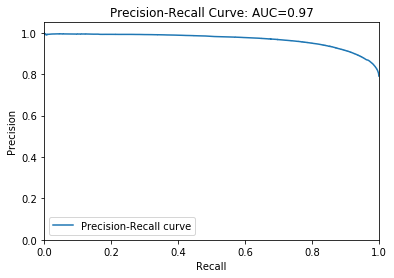

In [79]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

## PyStemmer (Unigrams only)

In [80]:
clf = MultinomialNB()

In [81]:
clf.fit(X_train_2_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [82]:
fnames = stemmed_tfidf_vect.get_feature_names()

In [83]:
print_top_features(fnames, clf, 50)

Most discriminative features:
 great, good, case, phone, love, work, not, product, perfect, fit, nice, like, protect, well, excel, use, screen, charg, one, look, price, easi, qualiti, protector, time, would, realli, thank, iphon, recommend, get, charger, need, buy, color, batteri, feel, bought, fast, cover, cabl, best, littl, drop, awesom, expect, purchas, item, much, instal


In [84]:
train_score = clf.score(X_train_2_tfidf, y_train) # Train Accuracy
test_score = clf.score(X_test_2_tfidf, y_test)    # Test Accuracy

In [85]:
predictions = clf.predict(X_test_2_tfidf)

In [86]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [87]:
cm

array([[ 23475,  54749],
       [  4052, 289856]], dtype=int64)

In [88]:
proba = clf.predict_proba(X_test_2_tfidf)

In [89]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [90]:
auc_score = auc(recall, precision)

In [91]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [92]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [93]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.84492
Test Accuracy        0.84199
Test Precision       0.84113
Test Recall          0.98621
F1                   0.90791
F2                   0.95333
P/R AUC              0.96741


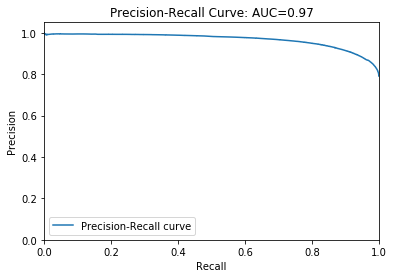

In [94]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

## PyStemmer (Unigrams/Bigrams)

In [95]:
clf = MultinomialNB()

In [96]:
clf.fit(X_train_2_tfidf_ngrams, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [97]:
fnames = stemmed_tfidf_ngrams_vect.get_feature_names()

In [98]:
print_top_features(fnames, clf, 50)

Most discriminative features:
 great, good, case, love, phone, work, not, product, nice, perfect, excel, fit, like, use, well, protect, charg, screen, one, look, price, works great, easi, thank, qualiti, protector, great product, time, would, realli, get, iphon, recommend, need, charger, screen protector, buy, batteri, awesom, color, bought, cabl, feel, expect, best, cover, littl, fast, ok, purchas


In [99]:
train_score = clf.score(X_train_2_tfidf_ngrams, y_train) # Train Accuracy
test_score = clf.score(X_test_2_tfidf_ngrams, y_test)    # Test Accuracy

In [100]:
predictions = clf.predict(X_test_2_tfidf_ngrams)

In [101]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [102]:
cm

array([[ 44866,  33358],
       [ 10008, 283900]], dtype=int64)

In [103]:
proba = clf.predict_proba(X_test_2_tfidf_ngrams)

In [104]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [105]:
auc_score = auc(recall, precision)

In [106]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [107]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [108]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.88903
Test Accuracy        0.88347
Test Precision       0.89486
Test Recall          0.96595
F1                   0.92904
F2                   0.95084
P/R AUC              0.97721


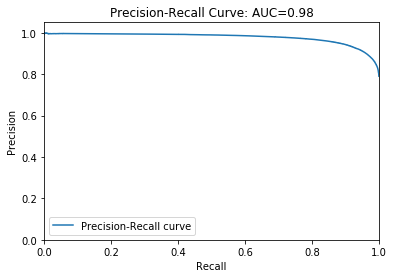

In [109]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()

## PyStemmer (Bigrams only)

In [110]:
clf = MultinomialNB()

In [111]:
clf.fit(X_train_2_tfidf_bigrams, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [112]:
fnames = stemmed_tfidf_bigrams_vect.get_feature_names()

In [113]:
print_top_features(fnames, clf, 50)

Most discriminative features:
 works great, great product, screen protector, great cas, good product, works wel, love cas, fits perfect, good qual, great pric, phone cas, excellent product, nice cas, highly recommend, easy instal, perfect fit, case fit, good cas, works perfect, looks great, case not, would recommend, really lik, good pric, great protect, well mad, protects phon, fast ship, great phon, phone not, great qual, cell phon, fit perfect, fits wel, fits phon, dropped phon, good protect, easy us, easy put, worked great, fits great, great fit, samsung galaxi, looks good, works fin, phone wel, would buy, phone perfect, high qual, protect phon


In [114]:
train_score = clf.score(X_train_2_tfidf_bigrams, y_train) # Train Accuracy
test_score = clf.score(X_test_2_tfidf_bigrams, y_test)    # Test Accuracy

In [115]:
predictions = clf.predict(X_test_2_tfidf_bigrams)

In [116]:
prec = precision_score(y_test, predictions) # Precision
rec = recall_score(y_test, predictions) # Recall
f1 = f1_score(y_test, predictions) # F1
f2 = fbeta_score(y_test, predictions, 2) # F2
cm = confusion_matrix(y_test, predictions)

In [117]:
cm

array([[ 39290,  38934],
       [  7291, 286617]], dtype=int64)

In [118]:
proba = clf.predict_proba(X_test_2_tfidf_bigrams)

In [119]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

In [120]:
auc_score = auc(recall, precision)

In [121]:
scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                  "Test Recall", "F1", "F2", "P/R AUC"]

In [122]:
scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

In [123]:
print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

Train Accuracy       0.88233
Test Accuracy        0.87578
Test Precision       0.88041
Test Recall          0.97519
F1                   0.92538
F2                   0.95464
P/R AUC              0.97152


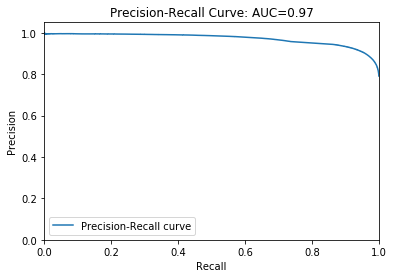

In [124]:
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
plt.legend(loc="lower left")
plt.show()